## 동기 비동기
### "values", "updates", "messages";

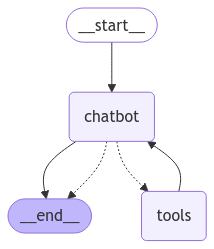

In [1]:
from dotenv import load_dotenv
from typing import Annotated, List, Dict
from typing_extensions import TypedDict
from langchain.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display

import sys
sys.path.append('../..')
from agent_tools.custom_tools import search_news


load_dotenv()


class State(TypedDict):
    messages: Annotated[list, add_messages]


@tool
def search_keyword(query: str) -> List[Dict[str, str]]:
    """Look up news by keyword"""
    return "\n".join([news["content"] for news in search_news.invoke(query)[:5]])


tools = [search_keyword]
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
tool_node = ToolNode(tools=[search_keyword])
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))


In [2]:
inputs = {"messages": [("human", "AI 관련된 최신 뉴스를 검색해줘")]}

stream_modes = ["values", "updates", "messages"]
for stream_mode in stream_modes:
    print(f"\n================== {stream_mode} ==================\n")
    
    print(f"\n================ Synchronous ================\n")
    if stream_mode == "messages":
        for chunk_msg, metadata  in graph.stream(inputs, stream_mode=stream_mode):
            if metadata["langgraph_node"] == "chatbot":
                if chunk_msg.content:
                    print(chunk_msg.content, end="", flush=True)
            else:
                print(chunk_msg.content)
                print(f"\n\nmetadata: \n{metadata}\n\n")
    else:
        for chunk in graph.stream(inputs, stream_mode=stream_mode):
            if stream_mode == "updates":
                for node, value in chunk.items():
                    if node:
                        print(f"\n[Node: {node}]\n")
                    if "messages" in value:
                        value["messages"][-1].pretty_print()
            else:
                for state_key, state_value in chunk.items():
                    if state_key == "messages":
                        state_value[-1].pretty_print()

    print(f"\n================ Asynchronous ===============\n")
    if stream_mode == "messages":
        async for chunk_msg, metadata in graph.astream(inputs, stream_mode=stream_mode):
            if metadata["langgraph_node"] == "chatbot":
                if chunk_msg.content:
                    print(chunk_msg.content, end="", flush=True)
            else:
                print(chunk_msg.content)
    else:
        final_result = None
        async for chunk in graph.astream(inputs, stream_mode=stream_mode):
            final_result = chunk
            if stream_mode == "updates":
                for node, value in chunk.items():
                    if node:
                        print(f"\n[Node: {node}]\n")
                    if "messages" in value:
                        value["messages"][-1].pretty_print()
            else:
                for state_key, state_value in chunk.items():
                    if state_key == "messages":
                        state_value[-1].pretty_print()
    
    if stream_mode == "values":
        print(f"\n=============== 최종 결과만 확인 ===============\n")
        print(final_result["messages"][-1].content)
    print()


================== values ==================


================ Synchronous ================

================================ Human Message =================================

AI 관련된 최신 뉴스를 검색해줘
================================== Ai Message ==================================
Tool Calls:
  search_keyword (call_iOYvJ66Vi6VRyCoBVpEOJMxk)
 Call ID: call_iOYvJ66Vi6VRyCoBVpEOJMxk
  Args:
    query: AI
================================= Tool Message =================================
Name: search_keyword

강기정 광주시장, 최상목 대행에 AI 2단계 예타 면제 요청
[특징주] LS일렉트릭, 머스크 AI개발사 납품 소식에 10% 급등
한국IBM, 노동부 주관 AI 전문 인재 양성 사업 참여
'AI교과서' 교사도 교육감도 엇갈린 반응…이주호 "재의 요구할 것"
'AI 교과서→교육자료' 거부권 임박…긴장 고조 속 오늘 청문회
================================== Ai Message ==================================

최근 AI 관련 뉴스는 다음과 같습니다:

1. **강기정 광주시장, 최상목 대행에 AI 2단계 예타 면제 요청** - 광주시장이 AI 관련 프로젝트의 예비타당성 조사를 면제해 달라고 요청했습니다.

2. **[특징주] LS일렉트릭, 머스크 AI 개발사 납품 소식에 10% 급등** - LS일렉트릭의 주가가 머스크의 AI 개발사에 납품 소식에 의해 10% 급등했습니다.

3. **한국IBM, 노동부 주관 AI 전문 인재 

## 특정 노드

#### --

In [ ]:
# from dotenv import load_dotenv
# from typing import Annotated, List, Dict
# from typing_extensions import TypedDict
# from langchain.tools import tool
# from langchain_openai import ChatOpenAI
# from langgraph.graph import StateGraph, START, END
# from langgraph.graph.message import add_messages
# from langgraph.prebuilt import ToolNode, tools_condition
# from IPython.display import Image, display

# import sys
# sys.path.append('../..')
# from agent_tools.custom_tools import search_news


# load_dotenv()


# class State(TypedDict):
#     messages: Annotated[list, add_messages]


# @tool
# def search_keyword(query: str) -> List[Dict[str, str]]:
#     """Look up news by keyword"""
#     return "\n".join([news["content"] for news in search_news.invoke(query)[:5]])


# tools = [search_keyword]
# llm = ChatOpenAI(model="gpt-4o-mini")
# llm_with_tools = llm.bind_tools(tools).with_config(tags=["WANT_TO_STREAM"])


# def chatbot(state: State):
#     return {"messages": [llm_with_tools.invoke(state["messages"])]}


# graph_builder = StateGraph(State)
# graph_builder.add_node("chatbot", chatbot)
# tool_node = ToolNode(tools=[search_keyword])
# graph_builder.add_node("tools", tool_node)
# graph_builder.add_conditional_edges(
#     "chatbot",
#     tools_condition,
# )
# graph_builder.add_edge("tools", "chatbot")
# graph_builder.add_edge(START, "chatbot")
# graph_builder.add_edge("chatbot", END)
# graph = graph_builder.compile()

# display(Image(graph.get_graph(xray=True).draw_mermaid_png()))


#### --

In [3]:
llm_with_tools = llm.bind_tools(tools).with_config(tags=["WANT_TO_STREAM"])

In [4]:
from langchain_core.messages import HumanMessage


inputs = {"messages": [("human", "AI 관련된 최신 뉴스를 검색해줘")]}

for chunk_msg, metadata in graph.stream(inputs, stream_mode="messages"):
    # HumanMessage 가 아닌 최종 노드의 유효한 컨텐츠만 출력 처리
    if (
        chunk_msg.content
        and not isinstance(chunk_msg, HumanMessage)
        and metadata["langgraph_node"] == "chatbot"
    ):
        print(chunk_msg.content, end="", flush=True)


최신 AI 관련 뉴스는 다음과 같습니다:

1. **강기정 광주시장, 최상목 대행에 AI 2단계 예타 면제 요청** - 광주시는 AI 관련 프로젝트에 대한 예비타당성 조사를 면제해 줄 것을 요청했습니다.

2. **[특징주] LS일렉트릭, 머스크 AI개발사 납품 소식에 10% 급등** - LS일렉트릭의 주가가 일론 머스크의 AI 개발사에 납품 소식으로 인해 10% 상승했습니다.

3. **한국IBM, 노동부 주관 AI 전문 인재 양성 사업 참여** - 한국IBM이 노동부가 주관하는 AI 전문 인재 양성 사업에 참여하기로 결정했습니다.

4. **'AI교과서' 교사도 교육감도 엇갈린 반응…이주호 "재의 요구할 것"** - AI 교과서에 대한 교사와 교육감 간의 의견이 엇갈리고 있으며, 이주호 교육부 장관은 재의 요구를 할 것이라고 밝혔습니다.

5. **'AI 교과서→교육자료' 거부권 임박…긴장 고조 속 오늘 청문회** - AI 교과서에 대한 거부권이 임박한 가운데, 관련 청문회가 열릴 예정입니다.

이와 관련된 더 많은 정보나 다른 질문이 있으시면 알려주세요!

In [5]:
metadata


{'langgraph_step': 3,
 'langgraph_node': 'chatbot',
 'langgraph_triggers': ['tools'],
 'langgraph_path': ('__pregel_pull', 'chatbot'),
 'langgraph_checkpoint_ns': 'chatbot:5ddef9e4-7f2f-1962-e56b-d864063c3304',
 'checkpoint_ns': 'chatbot:5ddef9e4-7f2f-1962-e56b-d864063c3304',
 'ls_provider': 'openai',
 'ls_model_name': 'gpt-4o-mini',
 'ls_model_type': 'chat',
 'ls_temperature': 0.7}

#### tag

In [7]:
# 비동기 이벤트 스트림 처리(astream_events)
async for event in graph.astream_events(inputs, version="v2"):
    kind = event["event"]
    tags = event.get("tags", [])

    # 채팅 모델 스트림 이벤트 및 최종 노드 태그 필터링
    # .with_config(tags=["WANT_TO_STREAM"])
    if kind == "on_chat_model_stream" and "WANT_TO_STREAM" in tags:
        data = event["data"]
        if data["chunk"].content:
            print(data["chunk"].content, end="", flush=True)


다음은 AI 관련 최신 뉴스입니다:

1. **강기정 광주시장, 최상목 대행에 AI 2단계 예타 면제 요청**
   - 광주시장이 AI 관련 프로젝트의 예비타당성 조사를 면제해 줄 것을 요청했습니다.

2. **[특징주] LS일렉트릭, 머스크 AI개발사 납품 소식에 10% 급등**
   - LS일렉트릭의 주가가 머스크의 AI 개발사에 납품 소식으로 인해 10% 상승했습니다.

3. **한국IBM, 노동부 주관 AI 전문 인재 양성 사업 참여**
   - 한국IBM이 노동부가 주관하는 AI 전문 인재 양성 사업에 참여하기로 했습니다.

4. **'AI교과서' 교사도 교육감도 엇갈린 반응…이주호 "재의 요구할 것"**
   - AI 교과서에 대한 교사와 교육감의 반응이 엇갈리고 있으며, 이주호 교육부 장관은 재의 요구를 하겠다고 밝혔습니다.

5. **'AI 교과서→교육자료' 거부권 임박…긴장 고조 속 오늘 청문회**
   - AI 교과서가 교육자료로 전환되는 것에 대한 거부권이 임박한 상황에서 청문회가 열릴 예정입니다. 

이와 관련된 더 많은 정보가 필요하시면 말씀해 주세요!

#### 도구 호출

In [8]:
from langchain_core.messages import AIMessageChunk, HumanMessage

first = True

# 비동기 스트림 처리를 통한 메시지 및 메타데이터 순차 처리
for msg, metadata in graph.stream(inputs, stream_mode="messages"):
    # 사용자 메시지가 아닌 경우의 컨텐츠 출력 처리
    if msg.content and not isinstance(msg, HumanMessage):
        print(msg.content, end="", flush=True)

    # AI 메시지 청크 처리 및 누적
    if isinstance(msg, AIMessageChunk):
        if first:
            gathered = msg
            first = False
        else:
            gathered = gathered + msg

        # 도구 호출 청크 존재 시 누적된 도구 호출 정보 출력
        if msg.tool_call_chunks:
            print(gathered.tool_calls[0]["args"])


{}
{}
{}
{'query': ''}
{'query': 'AI'}
{'query': 'AI'}
강기정 광주시장, 최상목 대행에 AI 2단계 예타 면제 요청
[특징주] LS일렉트릭, 머스크 AI개발사 납품 소식에 10% 급등
한국IBM, 노동부 주관 AI 전문 인재 양성 사업 참여
'AI교과서' 교사도 교육감도 엇갈린 반응…이주호 "재의 요구할 것"
'AI 교과서→교육자료' 거부권 임박…긴장 고조 속 오늘 청문회다음은 AI 관련 최신 뉴스입니다:

1. **강기정 광주시장, 최상목 대행에 AI 2단계 예타 면제 요청** - 광주시장이 AI 관련 프로젝트의 예비타당성 조사를 면제해달라고 요청했습니다.

2. **[특징주] LS일렉트릭, 머스크 AI개발사 납품 소식에 10% 급등** - LS일렉트릭의 주가가 일론 머스크의 AI 개발사에 납품 소식에 10% 상승했습니다.

3. **한국IBM, 노동부 주관 AI 전문 인재 양성 사업 참여** - 한국IBM이 노동부가 주관하는 AI 전문 인재 양성 사업에 참여하기로 했습니다.

4. **'AI교과서' 교사도 교육감도 엇갈린 반응** - AI 교과서에 대한 교사와 교육감의 반응이 엇갈리고 있으며, 이주호 교육부 장관은 재의 요구할 것이라고 밝혔습니다.

5. **'AI 교과서→교육자료' 거부권 임박** - AI 교과서를 교육자료로 전환하는 것에 대한 거부권이 임박했으며, 긴장 고조 속에 오늘 청문회가 예정되어 있습니다. 

더 궁금한 점이 있으시면 말씀해 주세요!

## Subgraphs 스트리밍

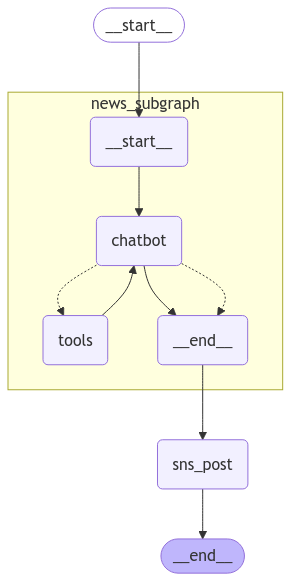

In [9]:
# 도구와 LLM 결합 (tags 추가)
llm_with_tools = llm.bind_tools(tools).with_config(tags=["WANT_TO_STREAM"])


# SNS 포스트 생성 함수 정의
def create_sns_post(state: State):
    # SNS 포스트 생성을 위한 프롬프트
    sns_prompt = """
    이전 대화 내용을 바탕으로 SNS 게시글 형식으로 변환해주세요.
    다음 형식을 따라주세요:
    - 해시태그 포함
    - 이모지 사용
    - 간결하고 흥미로운 문체 사용
    - 200자 이내로 작성
    """
    messages = state["messages"] + [("human", sns_prompt)]
    sns_llm = ChatOpenAI(model="gpt-4o-mini").with_config(tags=["WANT_TO_STREAM2"])
    return {"messages": [sns_llm.invoke(messages)]}


# 서브그래프 생성
def create_subgraph():
    subgraph = StateGraph(State)
    subgraph.add_node("chatbot", chatbot)
    tool_node = ToolNode(tools=[search_keyword])
    subgraph.add_node("tools", tool_node)
    subgraph.add_conditional_edges(
        "chatbot",
        tools_condition,
    )
    subgraph.add_edge("tools", "chatbot")
    subgraph.add_edge(START, "chatbot")
    subgraph.add_edge("chatbot", END)
    return subgraph.compile()


# 메인 그래프 생성
graph_builder = StateGraph(State)
subgraph = create_subgraph()
graph_builder.add_node("news_subgraph", subgraph)
graph_builder.add_node("sns_post", create_sns_post)
graph_builder.add_edge(START, "news_subgraph")
graph_builder.add_edge("news_subgraph", "sns_post")
graph_builder.add_edge("sns_post", END)
graph = graph_builder.compile()

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))


In [10]:
inputs = {"messages": [("human", "AI 관련된 최신 뉴스를 검색해줘")]}

for chunk in graph.stream(inputs, stream_mode="updates"):
    # node_name: 현재 처리 중인 노드명, node_chunk: 해당 노드의 청크 데이터
    for node_name, node_chunk in chunk.items():
        print(f"\n========= Update from node {node_name} =========\n")
        if "messages" in node_chunk:
            node_chunk["messages"][-1].pretty_print()
        else:
            print(node_chunk)



========= Update from node news_subgraph =========

================================== Ai Message ==================================

다음은 AI 관련 최신 뉴스입니다:

1. **강기정 광주시장, 최상목 대행에 AI 2단계 예타 면제 요청** - 광주시장이 AI 관련 프로젝트의 예비타당성 조사를 면제해 달라는 요청을 했습니다.

2. **[특징주] LS일렉트릭, 머스크 AI개발사 납품 소식에 10% 급등** - LS일렉트릭의 주가가 머스크의 AI 개발사에 납품 소식 덕분에 10% 상승했습니다.

3. **한국IBM, 노동부 주관 AI 전문 인재 양성 사업 참여** - 한국IBM이 노동부 주관의 AI 전문 인재 양성 프로그램에 참여합니다.

4. **'AI교과서' 교사도 교육감도 엇갈린 반응…이주호 "재의 요구할 것"** - 'AI 교과서'에 대한 교사와 교육감의 반응이 엇갈리고 있으며, 이주호 교육부 장관은 재의 요구를 할 것이라고 밝혔습니다.

5. **'AI 교과서→교육자료' 거부권 임박…긴장 고조 속 오늘 청문회** - 'AI 교과서'가 교육자료로 전환될 가능성이 높아지며, 관련 청문회가 오늘 열립니다. 

이와 관련된 더 많은 정보가 필요하시면 말씀해 주세요!

========= Update from node sns_post =========

================================== Ai Message ==================================

🚀 AI의 미래가 점점 더 가까워지고 있어요! 광주시장은 AI 프로젝트의 예타 면제를 요청하고, LS일렉트릭은 머스크 AI개발사와의 협력으로 주가가 10% 급등! 📈 한국IBM은 AI 인재 양성에 나섰고, 'AI 교과서' 논란이 계속되고 있답니다. 🤖💡 #AI #인공지능 #테크뉴스 #교육혁신 #LS일렉트릭


In [11]:
def format_namespace(namespace):
    return (
        namespace[-1].split(":")[0]
        if len(namespace) > 0
        else "parent graph"
    )

# subgraphs=True 를 통해 서브그래프의 출력도 포함(namespace, chunk) 형태로 출력됩니다.
for namespace, chunk in graph.stream(inputs, stream_mode="updates", subgraphs=True):
    for node_name, node_chunk in chunk.items():
        print(f"\n========= Update from node [{node_name}] in [{format_namespace(namespace)}] =========\n")
        if "messages" in node_chunk:
            node_chunk["messages"][-1].pretty_print()
        else:
            print(node_chunk)



========= Update from node [chatbot] in [news_subgraph] =========

================================== Ai Message ==================================
Tool Calls:
  search_keyword (call_fT1no8W6hecOfQalTggNu2Jx)
 Call ID: call_fT1no8W6hecOfQalTggNu2Jx
  Args:
    query: AI

========= Update from node [tools] in [news_subgraph] =========

================================= Tool Message =================================
Name: search_keyword

강기정 광주시장, 최상목 대행에 AI 2단계 예타 면제 요청
[특징주] LS일렉트릭, 머스크 AI개발사 납품 소식에 10% 급등
한국IBM, 노동부 주관 AI 전문 인재 양성 사업 참여
'AI교과서' 교사도 교육감도 엇갈린 반응…이주호 "재의 요구할 것"
'AI 교과서→교육자료' 거부권 임박…긴장 고조 속 오늘 청문회

========= Update from node [chatbot] in [news_subgraph] =========

================================== Ai Message ==================================

최근 AI 관련 뉴스는 다음과 같습니다:

1. **강기정 광주시장, 최상목 대행에 AI 2단계 예타 면제 요청** - 광주시장이 AI 관련 프로젝트에 대한 예비타당성 조사를 면제해 줄 것을 요청했습니다.

2. **[특징주] LS일렉트릭, 머스크 AI개발사 납품 소식에 10% 급등** - LS일렉트릭의 주가가 일론 머스크의 AI 개발사에 납품 소식에 힘입어 10% 상승했습니다.

3. **한국IBM, 노동부

In [ ]:
# 네임스페이스 정보를 파싱하는 함수
def parse_namespace_info(info: tuple) -> tuple[str, str]:
    if len(info) > 1:
        namespace, node_name = info
        return node_name.split(":")[0], namespace.split(":")[0]
    return info[0].split(":")[0], "parent graph"

kind = None

async for event in graph.astream_events(inputs, version="v2", subgraphs=True):
    kind = event["event"]

    # 이벤트 종류와 태그 정보 추출
    if kind == "on_chat_model_start":
        print(f"\n========= on_chat_model_start =========\n")

    # 채팅 모델 스트림 이벤트 및 최종 노드 태그 필터링
    elif kind == "on_chat_model_stream":
        # 이벤트 데이터 추출
        data = event["data"]

        # 토큰 단위의 스트리밍 출력
        if data["chunk"].content:
            print(data["chunk"].content, end="", flush=True)

    elif kind == "on_tool_start":
        print(f"\n========= tool_start =========\n")
        data = event["data"]
        if "input" in data:
            tool_msg = data["input"]
            print(tool_msg)            

    elif kind == "on_tool_end":
        print(f"\n========= tool_end =========\n")
        data = event["data"]
        if "output" in data:
            tool_msg = data["output"]
            print(tool_msg.content)



In [ ]:
# 네임스페이스 정보를 파싱하는 함수
def parse_namespace_info(info: tuple) -> tuple[str, str]:
    if len(info) > 1:
        namespace, node_name = info
        return node_name.split(":")[0], namespace.split(":")[0]
    return info[0].split(":")[0], "parent graph"

# 스트리밍 출력하고 싶은 tags 만 설정 (여기서는 "WANT_TO_STREAM" 는 출력에서 배제)
ONLY_STREAM_TAGS = ["WANT_TO_STREAM"]

kind = None
tags = None

async for event in graph.astream_events(inputs, version="v2", subgraphs=True):
    kind = event["event"]
    tags = event.get("tags", [])

    # 이벤트 종류와 태그 정보 추출
    if kind == "on_chat_model_start":
        print(f"\n========= tags: {tags} =========\n")

    # 채팅 모델 스트림 이벤트 및 최종 노드 태그 필터링
    elif kind == "on_chat_model_stream":
        for tag in tags:
            if tag in ONLY_STREAM_TAGS:
                # 이벤트 데이터 추출
                data = event["data"]

                # 출력 메시지
                if data["chunk"].content:
                    print(data["chunk"].content, end="", flush=True)
    elif kind == "on_tool_start":
        print(f"\n========= tool_start =========\n")
        data = event["data"]
        if "input" in data:
            tool_msg = data["input"]
            print(tool_msg)            

    elif kind == "on_tool_end":
        print(f"\n========= tool_end =========\n")
        data = event["data"]
        if "output" in data:
            tool_msg = data["output"]
            print(tool_msg.content)

